In [1]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

In [2]:
!ls -ltr
!hostname -i

127.0.1.1 


# Loading UD modules

In [3]:
from __future__ import print_function
import torch
import torch.optim as optim
from torchvision import datasets, transforms
from torch.optim.lr_scheduler import StepLR
from torchsummary import summary
from tqdm import tqdm
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import os 
import numpy as np
#mlflow
import mlflow
import mlflow.pytorch

# CUSTOM LIBRARY
import model_utility.data_utils as dutils
import model_utility.model_utils as mutils
import model_utility.plot_utils as putils 
import model_utility.regularization as regularization
import model_file.model_cifar as model_cifar
import model_utility.alb_utils as alb
import sys
sys.path.append('/home/abhinav/Documents/EVA5/session9/model_utility/gradcam')
import model_utility.grad_cam_viz as viz
import model_file.models as mod

# PLOTS
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
import data_augmentation.albumentations as A
from data_augmentation.albumentations.pytorch import ToTensor

In [5]:
A.__version__
A.__file__
A.Compose.__module__
A.Cutout.__module__
A.RandomCrop.__module__
A.HorizontalFlip.__module__
A.ElasticTransform.__module__
A.CoarseDropout.__module__
A.Normalize.__module__
A.pytorch.ToTensor.__module__
A.pytorch.ToTensor.__module__

'0.4.6'

'/home/abhinav/Documents/EVA5/session9/data_augmentation/albumentations/__init__.py'

'data_augmentation.albumentations.core.composition'

'data_augmentation.albumentations.augmentations.transforms'

'data_augmentation.albumentations.augmentations.transforms'

'data_augmentation.albumentations.augmentations.transforms'

'data_augmentation.albumentations.augmentations.transforms'

'data_augmentation.albumentations.augmentations.transforms'

'data_augmentation.albumentations.augmentations.transforms'

'data_augmentation.albumentations.pytorch.transforms'

'data_augmentation.albumentations.pytorch.transforms'

# Check GPU avaiability

In [6]:
device = dutils.get_device()

CUDA Available? True
Device is cuda:0


In [7]:
cuda = torch.cuda.is_available()
print(cuda)

True


# CIFAR10 Basics

In [8]:
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

SEED = 1
batch_size=128

# CUDA?
if device.type == 'cuda':
    torch.cuda.manual_seed(SEED)
else:
    torch.manual_seed(SEED)

# Load CIFAR10 dataset

In [9]:
os.getcwd()

'/home/abhinav/Documents/EVA5/session9'

In [10]:
path = os.getcwd()
path

'/home/abhinav/Documents/EVA5/session9'

In [11]:
batch_size = 128

In [12]:
# load CIFAR10 dataset
trainset, testset, train_loader, test_loader = alb.get_dataloader(batch_size=batch_size, num_workers=4, cuda = True,path = path)

Running over Cuda !!  True
Files already downloaded and verified
Files already downloaded and verified
mean 0.49186864
standard dev 0.24697131
mean 0.48265335
standard dev 0.24338901
mean 0.44717798
standard dev 0.26159254


/home/abhinav/anaconda3/lib/python3.8/site-packages/albumentations/augmentations/transforms.py:1469: DeprecationWarning: This class has been deprecated. Please use CoarseDropout
  warnings.warn("This class has been deprecated. Please use CoarseDropout", DeprecationWarning)
/home/abhinav/anaconda3/lib/python3.8/site-packages/albumentations/pytorch/transforms.py:57: DeprecationWarning: ToTensor is deprecated and will be replaced by ToTensorV2 in albumentations 0.5.0
  warnings.warn(


Files already downloaded and verified
Files already downloaded and verified


# Data mage Visualization

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

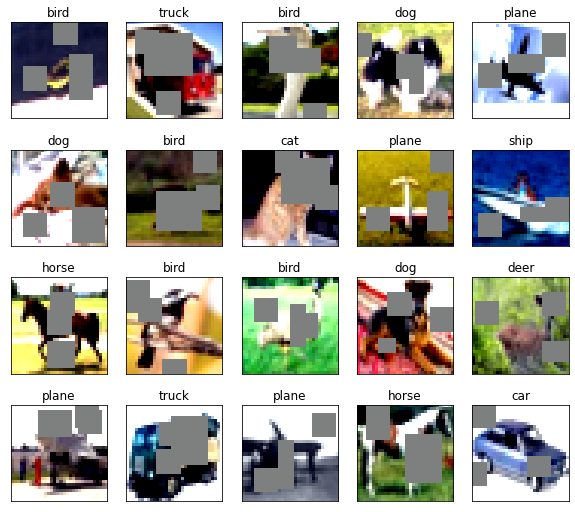

In [13]:
#Plot 20 random images
putils.plot_dataset_images(device, classes, train_loader)

### Model stracture

In [14]:
model = mod.ResNet18()

In [15]:
mutils.model_summary(model, device, input_size=(3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,728
       BatchNorm2d-2           [-1, 64, 32, 32]             128
            Conv2d-3           [-1, 64, 32, 32]          36,864
       BatchNorm2d-4           [-1, 64, 32, 32]             128
            Conv2d-5           [-1, 64, 32, 32]          36,864
       BatchNorm2d-6           [-1, 64, 32, 32]             128
        BasicBlock-7           [-1, 64, 32, 32]               0
            Conv2d-8           [-1, 64, 32, 32]          36,864
       BatchNorm2d-9           [-1, 64, 32, 32]             128
           Conv2d-10           [-1, 64, 32, 32]          36,864
      BatchNorm2d-11           [-1, 64, 32, 32]             128
       BasicBlock-12           [-1, 64, 32, 32]               0
           Conv2d-13          [-1, 128, 16, 16]          73,728
      BatchNorm2d-14          [-1, 128,

# Visual Summary

In [16]:
# from model_utility.plot_utils import  graphical_summary_cifar10
# graphical_summary_cifar10(model)

In [17]:
# Create CIFAR10 network
# model = model_cifar.Net(dropout_value = 0.05)
# mutils.model_summary(model, device, input_size=(3, 32, 32))

# Build and train model

In [18]:
from tqdm import tqdm

In [19]:
# build and train the model
model_name = "Model CIFAR10"
EPOCHS = 20
model =  model.to(device) # use GPU

# using L1 and L2 regularization
train_acc, train_losses, test_acc, test_losses = mutils.build_model(model, 
                                                            device, 
                                                            trainloader=train_loader, 
                                                            testloader=test_loader, 
                                                            epochs=EPOCHS,
                                                            L1_loss_flag=False,
                                                            L2_penalty_val=0.001)

  0%|          | 0/391 [00:00<?, ?it/s]

EPOCH: 0


  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 1.576650, Accuracy: 4162/10000 (41.62%)

EPOCH: 1


  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 1.774537, Accuracy: 3927/10000 (39.27%)

EPOCH: 2


  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 1.159564, Accuracy: 5826/10000 (58.26%)

EPOCH: 3


  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 1.032495, Accuracy: 6342/10000 (63.42%)

EPOCH: 4


  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.821872, Accuracy: 7107/10000 (71.07%)

EPOCH: 5


  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.887876, Accuracy: 7065/10000 (70.65%)

EPOCH: 6


  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.839532, Accuracy: 7139/10000 (71.39%)

EPOCH: 7


  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.909361, Accuracy: 7089/10000 (70.89%)

EPOCH: 8


  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.450435, Accuracy: 8471/10000 (84.71%)

EPOCH: 9


  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.429211, Accuracy: 8524/10000 (85.24%)

EPOCH: 10


  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.412112, Accuracy: 8568/10000 (85.68%)

EPOCH: 11


  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.428169, Accuracy: 8551/10000 (85.51%)

EPOCH: 12


  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.449768, Accuracy: 8514/10000 (85.14%)

EPOCH: 13


  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.453449, Accuracy: 8519/10000 (85.19%)

EPOCH: 14


  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.473408, Accuracy: 8512/10000 (85.12%)

EPOCH: 15


  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.490925, Accuracy: 8470/10000 (84.70%)

EPOCH: 16


  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.388834, Accuracy: 8742/10000 (87.42%)

EPOCH: 17


  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.391088, Accuracy: 8747/10000 (87.47%)

EPOCH: 18


  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.389377, Accuracy: 8765/10000 (87.65%)

EPOCH: 19


Loss=0.092068 Batch_id=390 Accuracy=97.27: 100%|██████████| 391/391 [00:47<00:00,  8.27it/s]



Test set: Average loss: 0.392144, Accuracy: 8766/10000 (87.66%)



In [20]:
A.__file__

'/home/abhinav/Documents/EVA5/session9/data_augmentation/albumentations/__init__.py'

# Test Accuracy

In [21]:
mutils.get_test_accuracy(model, device, test_loader)


Accuracy of the network on the 10000 test images: 87.66%



### Class level Accuracy

In [22]:

mutils.class_based_accuracy(model, device, classes, test_loader)

Accuracy of plane : 87 %
Accuracy of   car : 96 %
Accuracy of  bird : 80 %
Accuracy of   cat : 70 %
Accuracy of  deer : 83 %
Accuracy of   dog : 74 %
Accuracy of  frog : 88 %
Accuracy of horse : 88 %
Accuracy of  ship : 95 %
Accuracy of truck : 97 %


# Visualization


Ploting Accuracy and Loss history: Model CIFAR10



/home/abhinav/Documents/EVA5/session9/model_utility/plot_utils.py:27: MatplotlibDeprecationWarning: Passing the minor parameter of set_xticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  axs[0].set_xticks(np.arange(1,x_size+1),x_size/10)
/home/abhinav/Documents/EVA5/session9/model_utility/plot_utils.py:38: MatplotlibDeprecationWarning: Passing the minor parameter of set_xticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  axs[1].set_xticks(np.arange(1,x_size+1),x_size/10)


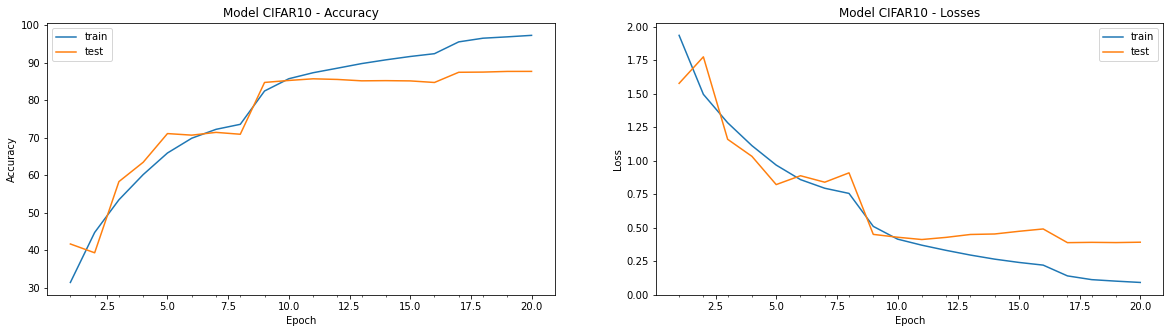

In [23]:
print("\nPloting Accuracy and Loss history: {}\n".format(model_name))
putils.plot_model_history(model_name, 
                   train_acc,test_acc,
                   train_losses,test_losses,
                   save_filename = "model_history")

# Misclassified images


Ploting misclassified images: Model CIFAR10



/home/abhinav/Documents/EVA5/session9/model_utility/plot_utils.py:86: UserWarning: This overload of nonzero is deprecated:
	nonzero()
Consider using one of the following signatures instead:
	nonzero(*, bool as_tuple) (Triggered internally at  /opt/conda/conda-bld/pytorch_1595629395347/work/torch/csrc/utils/python_arg_parser.cpp:766.)
  wrong_idx = (pred_marker == False).nonzero()  # get indices for wrong predictions
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the val

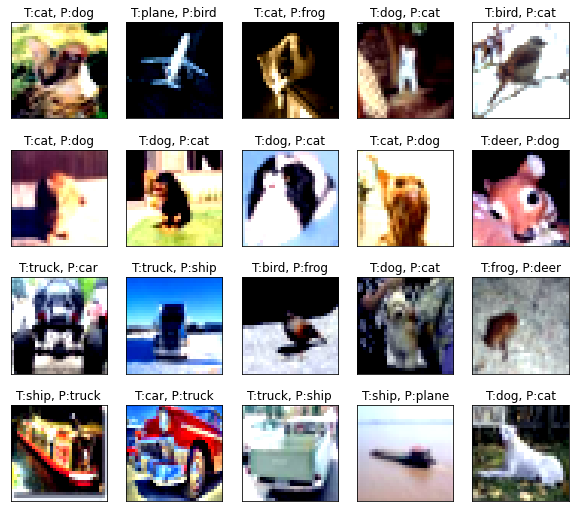

In [24]:
print ("\nPloting misclassified images: {}\n".format(model_name))

putils.miss_classification('Test',model, 
                          device, 
                          classes,
                          testloader=test_loader,
                          num_of_images = 20,
                          save_filename="model_misclassified")

/home/abhinav/anaconda3/lib/python3.8/site-packages/torch/nn/functional.py:2941: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


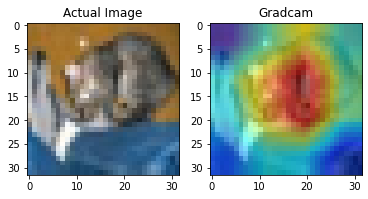

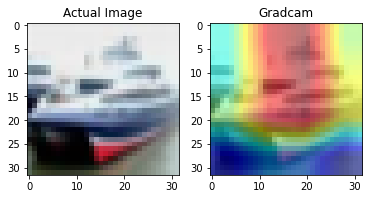

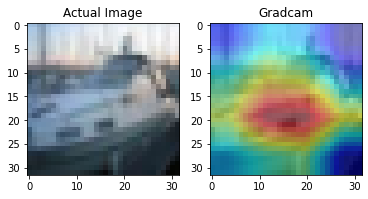

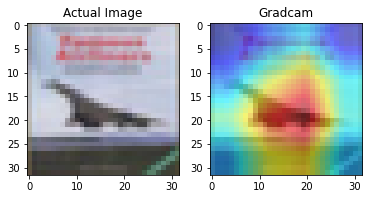

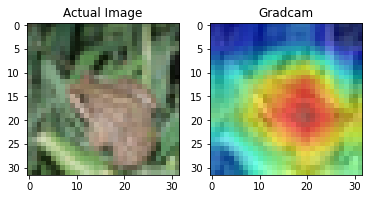

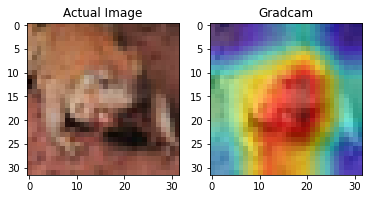

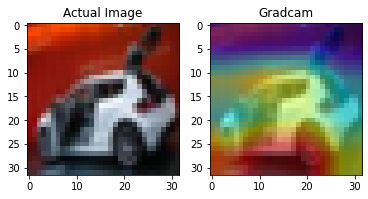

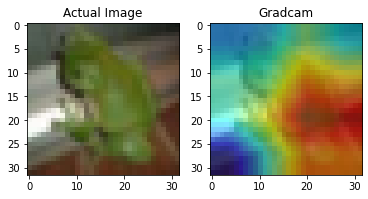

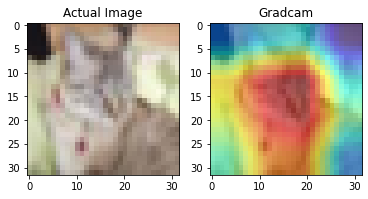

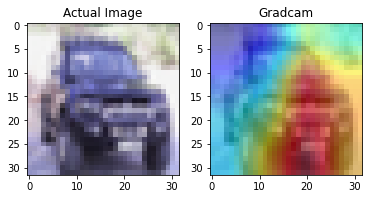

In [26]:
layer = 'layer4'
viz.gradcam_plot(layer,model,testset,classes)

In [27]:
with mlflow.start_run() as run:
    mlflow.log_param("epochs", EPOCHS)
    mlflow.pytorch.log_model(model, "models")